# DLToolboxImg: Part 2
A set of helper functions that one repeatedly need to construct a dataset from raw images, visualise the performance of a neural network while it is getting trained, evaluate the performance of a model after training is completed. 

As a running example, I will apply the functinos on the LIDC dataset.

# Table of Contents
- [Generate Dataset](#generatedata)
    - [Generate Positive Examples](#pos)
    - [Generate Negative Examples](#neg)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib nbagg

In [2]:
from imports import *

<a id="generatedata"></a>
## Generate Dataset 

### Load the indices for train, valid, and test sets

In [3]:
root_dir="drive/"
interm_dir=root_dir+"interm5/"
filename=interm_dir+"scan_id_split"
with open(filename, 'rb') as f:  # Python 3: open(..., 'wb')
    scan_id_train,scan_id_valid,scan_id_test=pickle.load(f)

In [4]:
scan_id_train,scan_id_valid,scan_id_test

([15, 16, 17, 20, 22, 23], [19], [18, 21, 14])

### Generate Positive Examples
<a id="pos"></a>

In [5]:
!mkdir /home/mas/x110/data/
!mkdir /home/mas/x110/data/pos

mkdir: cannot create directory ‘/home/mas/x110/data/’: File exists
mkdir: cannot create directory ‘/home/mas/x110/data/pos’: File exists


In [6]:
interm_dir2='/home/mas/x110/data/pos'

In [7]:
#choose a scan
scan_id = scan_id_train[0]
scan_1 = ctscan(scan_id) 
scan_id

Loading dicom files ... This may take a moment.


15

In [8]:
#we would like to extract a 52x52x52 patch from the ctscan volume.
#The patch is centered at the noduel centroid
m = 52
cx,cy,cz = scan_1.centroids2[0]
cx,cy,cz

(115, 264, 93)

In [9]:
#grap the volume
image=scan_1.image_normalized #zxy
image.shape

(301, 421, 421)

In [10]:
cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)

In [11]:
cube_img.shape

(52, 52, 52)

<IPython.core.display.Javascript object>


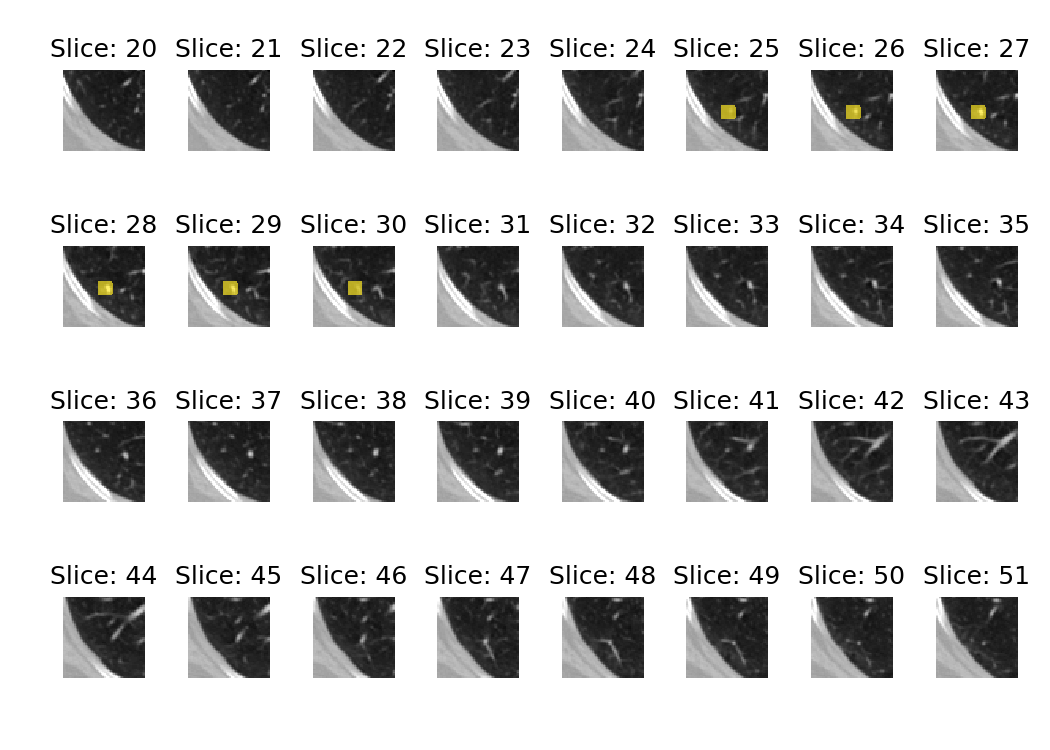

In [12]:
zs=32

X2 = cube_img.copy()
Z2=cube_label.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=4
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(7,5))

ind=np.arange(20,65)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("Slice: "+str(ii))
      
plt.tight_layout()

Now repeat the process on the full dataset

In [13]:
for scan_id in scan_id_train:#[xx+1:]:
    try:
        scan_1 = ctscan(scan_id) 
        m=52
        for cx,cy,cz in scan_1.centroids2:
            ### extract a cube with a centroid and size 32x32x32 for image
            image=scan_1.image_resampled #xyz
            image=image.swapaxes(2,1)
            image=image.swapaxes(0,1)
            cube_img,corner0 = get_cube_from_img(image, cx, cy, cz, m)
            cube_label,corner1 = get_cube_from_img(scan_1.Z2, cx, cy, cz, m)

            filename=intermdir2+'/data_P_'+str(scan_id)+"_"+str(cx)+"_"+str(cy)+"_"+str(cz)+".pkl"
            with open(filename, 'wb') as f:  # Python 3: open(..., 'wb')
                pickle.dump([cube_img,cube_label.astype(np.bool)], f)
    except:
        continue
                                                       
#x=[i for i,j in enumerate(scan_id_train) if j==scan_id]
#xx=x[0]

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


### Generate Negative Examples
<a id="neg"></a>

1. get a scan
2. Apply the lung mask 
3. break the volume into patches serially
4. label each patch as pos (contains a nodue) or neg (does not include nodule)
5. The naming convention would be pos_scan_id_cx_cy_cz or neg_scan_id_cx_xy_cz

In [5]:
#choose a scan
scan_id = scan_id_train[0]
scan_1 = ctscan(scan_id) 
scan_id

Loading dicom files ... This may take a moment.


15

In [6]:
S,B=get_segmented_lungs2(scan_1.image_resampled, plot=False)

/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


In [7]:
S.shape

(301, 421, 421)

In [20]:
T = B.shape[1]**2

In [21]:
Areas=[np.sum(b)/T for b in B]

<IPython.core.display.Javascript object>


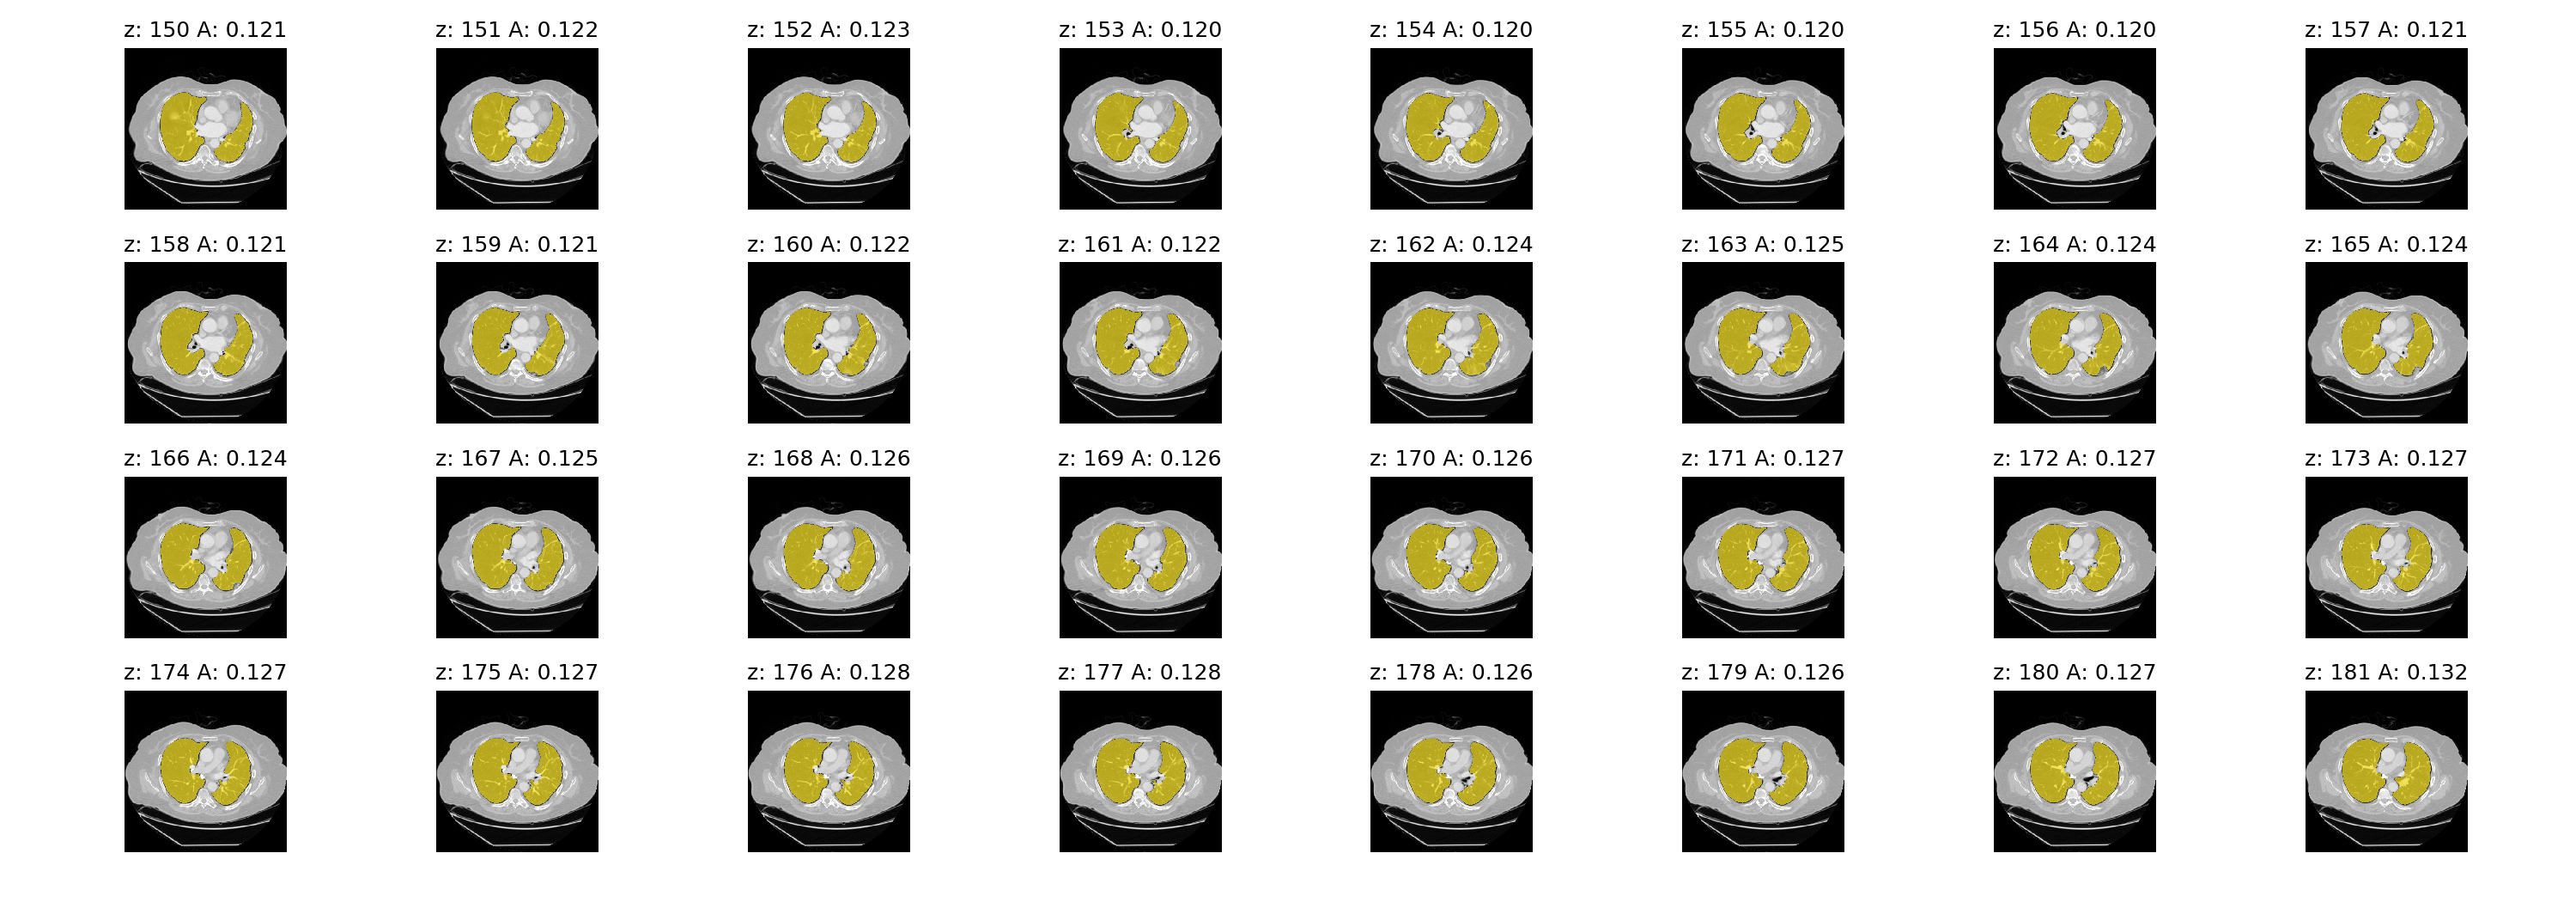

In [24]:
zs=32

X2 = scan_1.image_normalized.copy()
Z2=B.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=4
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(20,7))

ind=np.arange(150,301)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("z: "+str(ii)+' A: '+str(Areas[ii])[0:5])
      
plt.tight_layout()

<IPython.core.display.Javascript object>


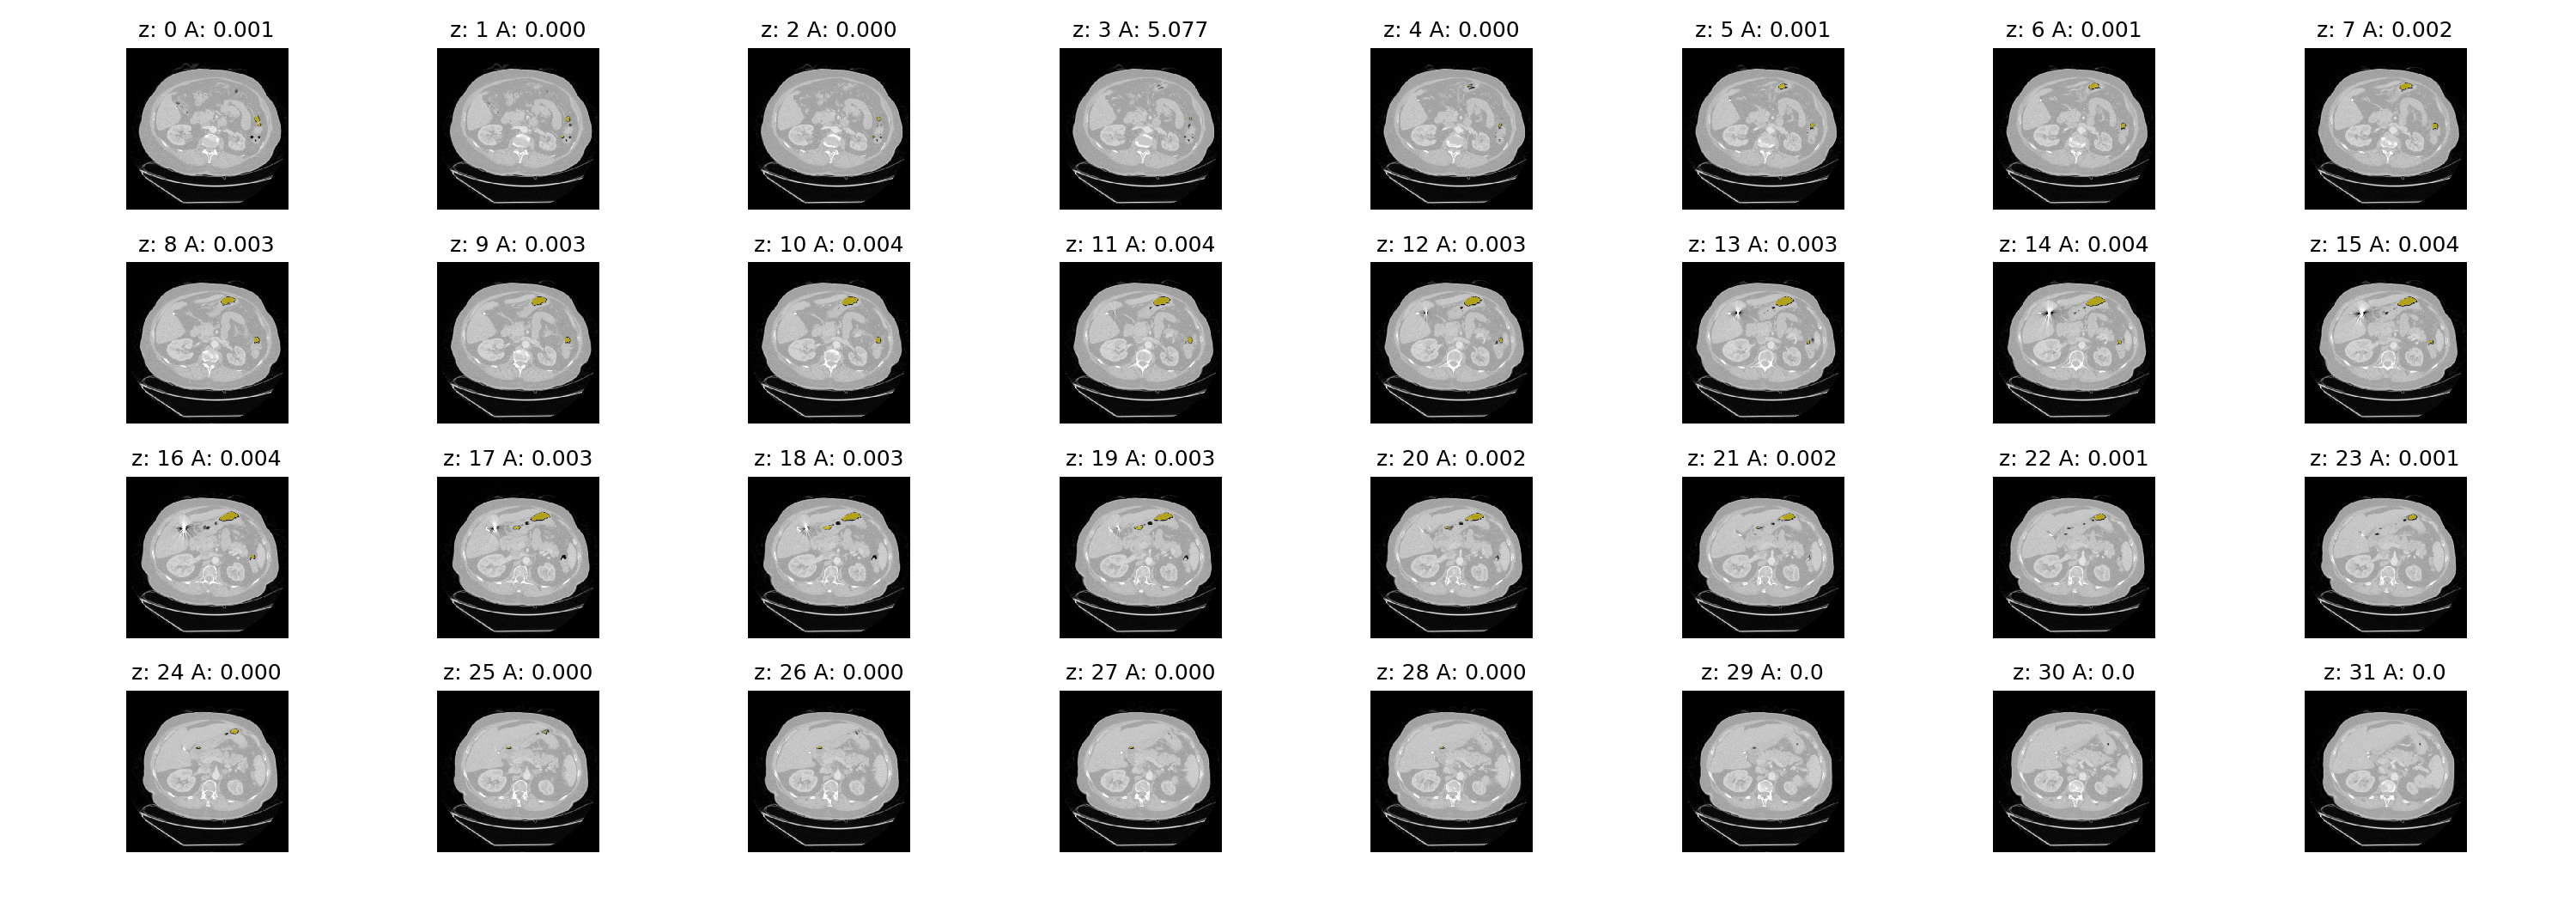

In [25]:
zs=32

X2 = scan_1.image_normalized.copy()
Z2=B.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=4
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(20,7))

ind=np.arange(0,32)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("z: "+str(ii)+' A: '+str(Areas[ii])[0:5])
      
plt.tight_layout()

In [26]:
Areas

[0.0010607026590912939,
 0.0006206238962768208,
 0.0003272380544005055,
 5.077831878628534e-05,
 0.00026517566477282347,
 0.0012243216862915466,
 0.0019803544326651283,
 0.0026856088602524248,
 0.0033513690398948325,
 0.0038591522277576858,
 0.0040848336445856205,
 0.0040848336445856205,
 0.003921214617385368,
 0.003932498688226765,
 0.004152538069634002,
 0.004197674352999588,
 0.004090475680006319,
 0.003909930546543971,
 0.003926856652806066,
 0.0035488402796192754,
 0.0028830800999768676,
 0.0022737402745414436,
 0.0016587584136853212,
 0.0011791854029259597,
 0.0009647880569394214,
 0.00041751062113167946,
 0.00024260752309002997,
 0.0001805451334623479,
 0.00010719867299326905,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.206238962768208e-05,
 0.0001184827438346658,
 0.0002538915939314267,
 0.0005190672587042502,
 0.0006770442504838045,
 0.0009252938089945328,
 0.0011340491195603727,
 0.0013766566426504025,
 0.0015910539886369406,
 0.0017490309804164951,
 0.0020311327514514134,
 

In [39]:
ind2=[i for i,a in enumerate(Areas) if a>.05]

In [40]:
len(ind2)

171

In [41]:
ind2

[84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 2

<IPython.core.display.Javascript object>


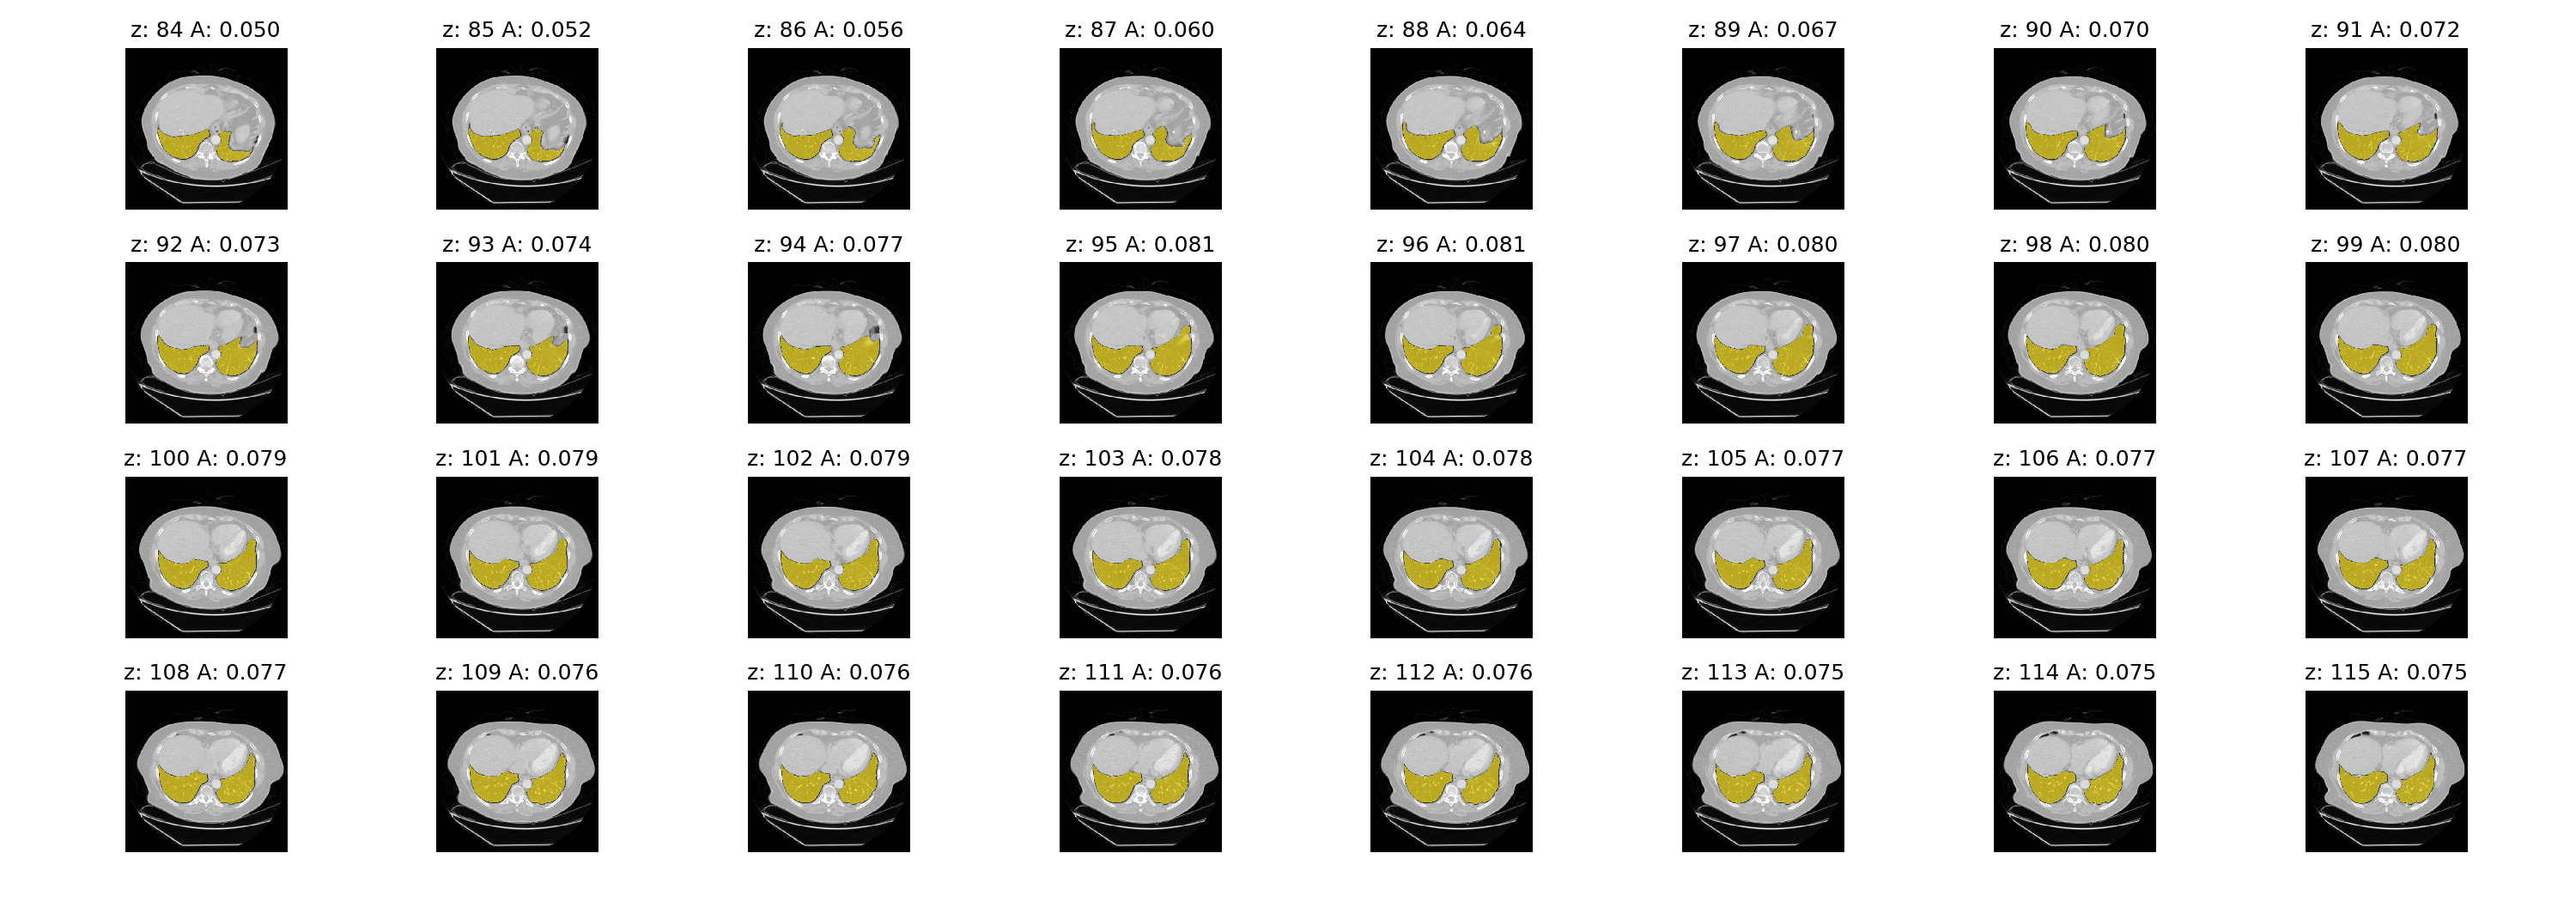

In [42]:
zs=32

X2 = scan_1.image_normalized.copy()
Z2=B.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=4
num_cols=8

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(20,7))

ind=np.arange(84,130)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("z: "+str(ii)+' A: '+str(Areas[ii])[0:5])
      
plt.tight_layout()

In [43]:
#look into the relation of nodule and slice location

In [45]:
zs=[]
for scan_id in scan_id_train:#[xx+1:]:
    scan_1 = ctscan(scan_id) 
    for cx,cy,cz in scan_1.centroids2:
        zs.append(cz)



Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


In [48]:
df=pd.DataFrame(zs,columns=['nodule_diameter'])

In [52]:
df.head()

nodule_diameter
0               93
1               95
2               93
3               95
4              192

<IPython.core.display.Javascript object>


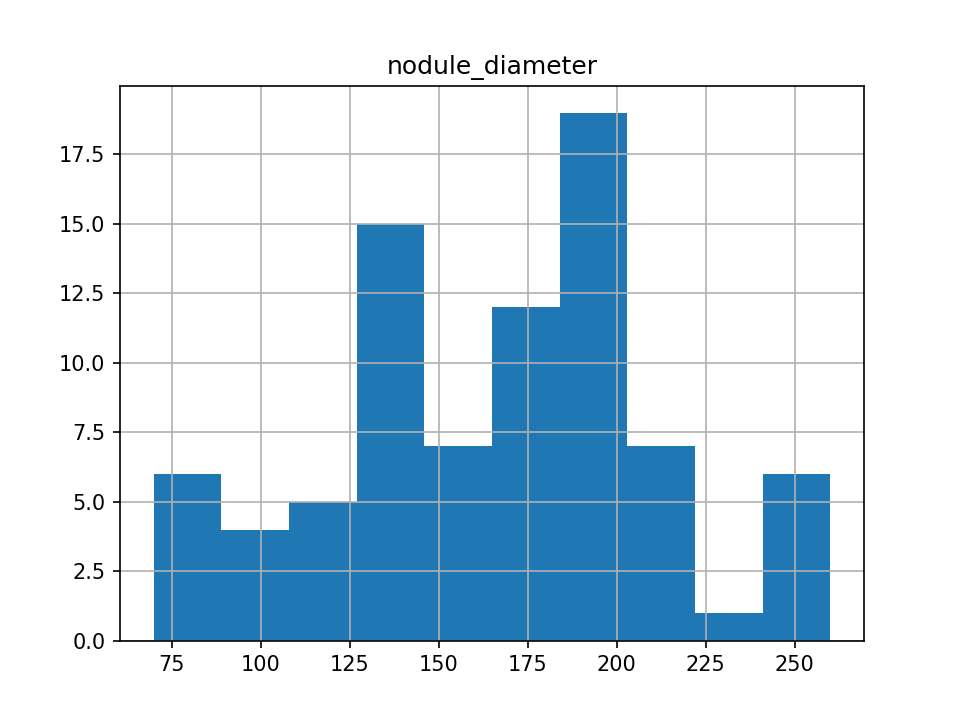

In [50]:
df.hist(column='nodule_diameter')
plt.show()

In [51]:
B.shape

(301, 421, 421)

252.1065657715066